In [1]:
%pylab inline

from lib.KDTreeEncoding import *

import xgboost as xgb
from lib.XGBHelper import *
from lib.XGBoost_params import *
from lib.score_analysis import *

from lib.logger import logger

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from numpy import load
from glob import glob
import pandas as pd
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
# setting up random seed, it has been set in all helper lib too
np.random.seed(123)

In [3]:
# set path to directories here
poverty_dir = '/datasets/cs255-sp22-a00-public/poverty/'
image_dir = poverty_dir + '/anon_images'
train_table = '../public_tables/train.csv'

In [4]:
# creating main dataframe and image files here
df=pd.read_csv(train_table,index_col=0)
df.index = df['filename']
files=list(glob(f'{image_dir}/*.npz'))

In [ ]:
## Pickled the encoded dataset, so can skip this cell if no changes are being made here (pickle again if Yes)
## Getting features from the images in the main dataframe Enc_data using KD-trees
## Can think of changes here to extract features from the images in a different manner
## max_images = 610 works, but 615 will run out of memory and kernel dies
## try changing the randomness factor here file choosing images to use for encoding
## tree depth: (2^(tree_depth+1))+1 will decide how many columns we will be having in our encoded dataset
## so right now 1024+1 columns will be used to encode the image data as a feature vector
tree_depth = 9
train_size,tree=train_encoder(files,max_images=610,tree_depth=tree_depth)
Enc_data=encoded_dataset(image_dir,df,tree, depth=tree_depth, label_col='label')

In [ ]:
# saving this encoded dataset and tree so that we don't have to encode it every time
# run this cell only if you have made changes to the encoding design
encoded_dataset=f'encoded_dataset.pk'
encoder_tree=f'encoder_tree.pk'
pkl.dump(Enc_data,open(encoded_dataset,'wb'))
pkl.dump(tree, open(encoder_tree,'wb'))

In [5]:
# run this cell to load the encoded dataset and tree 
encoded_dataset=f'encoded_dataset.pk'
encoder_tree = f'encoder_tree.pk'
Enc_data = pkl.load(open(encoded_dataset,'rb'))
tree = pkl.load(open(encoder_tree,'rb'))

In [6]:
# Creating object D to handle dataset functionalities
# like getting subsets, bootstrapping samples, etc
D = DataSplitter(Enc_data.data)

In [7]:
# creating a new metric for our XGBoost algorithm
from sklearn.metrics import f1_score, recall_score

def calc_f1(predt: np.ndarray, dtrain: xgb.DMatrix):
    preds = (predt > 0.5).astype(np.int64)
    res = f1_score(predt>0.5, dtrain.get_label())
    return 'f1', res



In [8]:
# Set all params for XGBoost here
# param dictionary is already present in the lib.XGBoost_Params file
# default parameters are set, can be customized and new params can also be added
param['max_depth'] = 3   # depth of tree
param['eta'] = 0.18      # shrinkage parameter
param['verbosity'] = 0  # 0= no logging 3=max logging
param['feature_selector'] = 'shuffle'
# added parameters from tanmay's part
param['verbose_eval'] = 0 
param['early_stopping_rounds'] = 15
#param['eval_metric'] = ['auc']
param['feature_selector'] = 'shuffle'
param['custom_metric'] = calc_f1
param['disable_default_eval_metric']=True


# param['objective'] = 'binary:logistic'
# param['nthread'] = 7 # Number of threads used
param['eval_metric'] = ['error','logloss']
param

{'max_depth': 3,
 'eta': 0.18,
 'verbosity': 0,
 'objective': 'binary:logistic',
 'nthread': 7,
 'eval_metric': ['error', 'logloss'],
 'feature_selector': 'shuffle',
 'verbose_eval': 0,
 'early_stopping_rounds': 15,
 'custom_metric': <function __main__.calc_f1(predt:numpy.ndarray, dtrain:xgboost.core.DMatrix)>,
 'disable_default_eval_metric': True}

In [9]:
# deciding which rows in dataset to select [True, False, False, True,.....]
train_selector=np.random.rand(df.shape[0]) > 0.5
# subset selecting everything which is True as Train set
Train=D.get_subset(train_selector)
# subset selecting everything which is False as Test set
Test=D.get_subset(~train_selector)

# checking the size of the train and test dataset train should be more
print("Training subset has: ", Train.shape[0], " samples")
print("Testing subset has: ", Test.shape[0], " samples")

Training subset has:  5729  samples
Testing subset has:  5636  samples


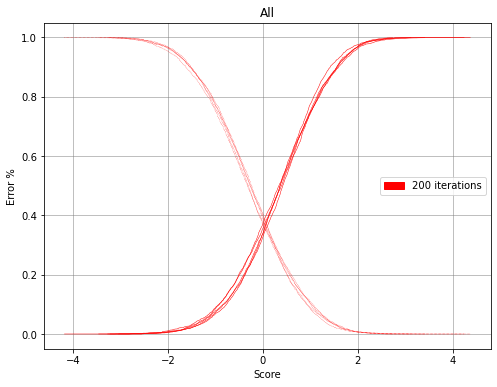

In [10]:
param['num_round']=200
log200=simple_bootstrap('xgb',Train,Test,param,ensemble_size=5)

styled_logs=[    
    {   'log':log200,
        'style':['r:','r-'],
        'label':'200 iterations',
        'label_color':'r'
    }
]
_mean,_std=plot_scores(styled_logs,title='All')

pickle_file=f'data/Checkpoint.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



In [ ]:
# Only for Urban Areas now
urban=True
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['g:','g-'],
        'label':'10 iterations',
        'label_color':'g'
    },
    {   'log':log100,
        'style':['b:','b-'],
        'label':'100 iterations',
        'label_color':'b'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))



In [ ]:
_mean, _std

In [ ]:
urban=False
area= 'Urban' if urban else 'Rural'
selector=df['urban']==urban
subData=D.get_subset(selector)
subD=DataSplitter(subData)

train_selector=np.random.rand(subData.shape[0]) > 0.7
Train=subD.get_subset(train_selector)
Test=subD.get_subset(~train_selector)

param['num_round']=10
log10=simple_bootstrap(Train,Test,param,ensemble_size=30)
param['num_round']=100
log100=simple_bootstrap(Train,Test,param,ensemble_size=30)

styled_logs=[
    {   'log':log10,
        'style':['y:','y-'],
        'label':'10 iterations',
        'label_color':'y'
    },
    {   'log':log100,
        'style':['m:','m-'],
        'label':'100 iterations',
        'label_color':'m'
    }
]

_mean,_std=plot_scores(styled_logs,title=f'{area}Only: Split into train and test at random')

pickle_file=f'data/Dump{area}.pk'
Dump={'styled_logs':styled_logs,
     'tree':tree,
     'mean':_mean,
     'std':_std}
pkl.dump(Dump,open(pickle_file,'wb'))

